In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

# Machine Learning

#### 1) Gere uma amostra de 500 dados a partir de um polinômio de grau 4 com ruído. Compare os seguintes modelos Linear, Quadrático, Cúbico e Quártico construídos a partir de amostras com os seguintes tamanhos: 5, 10, 25, 50 e 100.

In [ ]:
def generate_data(coefficients, from_to, num_points, noise_scale):

    # Gerando valores de x
    x = np.linspace(*from_to, num_points)
    # Gerando ruído
    noise = np.random.normal(loc=0, scale=noise_scale, size=len(x))
    # Gerando valores de y sem ruído
    y_true = np.polyval(coefficients, x)
    # Gerando valores de y com ruído
    y = y_true + noise

    return x, y, y_true

In [ ]:
x, y, y_true = generate_data(coefficients=[1, -4, -1, 10, 0], from_to=[-2, 4], num_points=500, noise_scale=1)

plt.scatter(x, y, label="Série com Ruído", alpha=0.6, s=10)
plt.plot(x, y_true, color="red")
plt.title("Dados Gerados")
plt.show()

In [ ]:
# Função para ajustar um modelo polinomial a uma amostra de dados

def fit_model(x, x_sample, y_sample, degree):
    # Obtendo coeficientes de um polinômio de grau especificado que se ajusta à amostra
    coeffs = np.polyfit(x_sample, y_sample, degree)
    model = np.poly1d(coeffs)
    y_pred = model(x)

    return coeffs, model, y_pred

def plot_model(x_range, x_sample, y_sample, y_true, y_pred, degree, ax):
    # Plotando amostra, polinômio original e modelo ajustado
    ax.scatter(x_sample, y_sample, label=f"Amostra ({len(x_sample)})", color='blue')
    ax.plot(x_range, y_true, color='red', label="Polinômio Original")
    ax.plot(x_range, y_pred, color='green', label="Modelo Predito (Grau {})".format(degree))
    ax.legend()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Ajustando com grau {degree}")

# Criando uma matriz de plots para comparar modelos com diferentes graus
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Ajustando modelos de diferentes graus a uma amostra de dados", fontsize=16)

# Tamanho das amostras que serão usadas para ajustar os modelos de graus 1, 2, 3 e 4
sample_sizes = [5, 15, 25, 50]

# Gerando e ajustando modelos para diferentes graus
for i, sample_size in enumerate(sample_sizes):
    # Obtendo amostra de dados aleatória
    xy = list(zip(x, y))
    np.random.shuffle(xy)
    x_sample, y_sample = zip(*xy[:sample_size])
    degree = i + 1
    
    # Acessamos os plots da matriz usando axs[i // 2, i % 2] (divisa inteira e resto da divisão)
    # i // 2 é a linha e i % 2 é a coluna
    # i varia de 0 a 3, então i // 2 varia de 0 a 1 e i % 2 varia de 0 a 1
    # assim, acessamos os plots (0, 0), (0, 1), (1, 0) e (1, 1) da matriz

    coeffs, model, y_pred = fit_model(x, x_sample, y_sample, degree)
    plot_model(x, x_sample, y_sample, y_true, y_pred, degree, axs[i // 2, i % 2])

plt.tight_layout()
plt.show()


In [ ]:
x, y, y_true = generate_data(coefficients=[1, -4, -1, 10, 0], from_to=[-2, 4], num_points=40, noise_scale=1)

In [ ]:
# Ajustando Modelos
coeffs_1, model_1, y_pred_1 = fit_model(x=x, x_sample=x, y_sample=y, degree=1)
coeffs_2, model_2, y_pred_2 = fit_model(x=x, x_sample=x, y_sample=y, degree=2)

In [ ]:
# Plotando Modelos
fig, ax = plt.subplots(figsize=(6, 5))
plot_model(x_range=x, y_sample=y, x_sample=x, y_true=y_true, y_pred=y_pred_1, degree=1, ax=ax)
fig2, ax2 = plt.subplots(figsize=(6, 5))
plot_model(x_range=x, y_sample=y, x_sample=x, y_true=y_true, y_pred=y_pred_2, degree=2, ax=ax2)


#### 2) Gere uma amostra de 40 dados a partir de um polinômio de grau 4 com ruído.
##### a) Estime um modelo Linear e um modelo Quadrático e compare esses modelos usando um conjunto de validação.
##### b) Explore o efeito do tamanho do conjunto de validação k na estimativa. Ou seja, brinque com um Monte Carlo para calcular a variância do Erro de validação e a variância de um dos parâmetros do modelo. Note que se o tamanho k do conjunto de validação aumenta, então o tamanho da amostra de treino 40 − k diminui.

In [ ]:
def split_data(x, y, validation_size):
    # Embaralhando os índices dos dados
    indices = np.arange(len(x))
    np.random.shuffle(indices)

    # Dividindo os dados em conjuntos de treinamento e validação
    validation_indices = indices[:validation_size]
    training_indices = indices[validation_size:]
    x_validation, y_validation = x[validation_indices], y[validation_indices]
    x_training, y_training = x[training_indices], y[training_indices]

    return x_training, y_training, x_validation, y_validation

In [ ]:
def evaluate_model(x_training, y_training, x_validation, y_validation, degree):
    # Ajustando o modelo com os dados de treinamento
    coeffs = np.polyfit(x_training, y_training, degree)
    model = np.poly1d(coeffs)

    # Predizendo valores de y com o modelo para os dados de validação
    y_pred = model(x_validation)

    def calculate_error(y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    # Calculando o erro de validação
    error = calculate_error(y_validation, y_pred)

    return error, coeffs


def monte_carlo_experiment(x, y, degrees, validation_sizes, num_iterations):
    errors = np.zeros((len(validation_sizes), len(degrees), num_iterations))
    coeffs_dict = {degree:{i : [] for i in validation_sizes} for degree in degrees}
    coeffs_variances = {degree:{i : [] for i in validation_sizes} for degree in degrees}

    for d, degree in enumerate(degrees):
        for v, validation_size in enumerate(validation_sizes):
            for i in range(num_iterations):
                x_training, y_training, x_validation, y_validation = split_data(x, y, validation_size=validation_size)
                error, coeffs = evaluate_model(x_training, y_training, x_validation, y_validation, degree)

                errors[v, d, i] = error
                coeffs_dict[degree][validation_size].append(list(coeffs))

                # if (i + 1) % 10 == 0:
                #     print(f"Iteração {i + 1}/{num_iterations} - Tamanho do conj. valid.: {validation_size} - Grau: {degree}")
                #     print(f"Erro de Validação: {error:.4f} - Coeficientes: {coeffs}\n")

    # Obtendo a variância de cada coeficiente para cada grau e tamanho de validação
    for degree in coeffs_dict.keys():
        for validation_size in coeffs_dict[degree].keys():
            coeffs_variances[degree][validation_size] = list(np.var(coeffs_dict[degree][validation_size], axis=0))

    # Calculando a média dos erros para cada grau e tamanho de validação
    mean_errors = np.mean(errors, axis=2)
    
    return mean_errors, coeffs_variances

In [ ]:
# Parâmetros do experimento de Monte Carlo
degrees = [1, 2]  # Modelos de grau 1 e 2
validation_sizes = [5, 10, 15, 20, 25, 30]  # Tamanhos de amostra para validação
num_iterations = 10000  # Número de iterações do experimento

mean_errors, coeffs_variances = monte_carlo_experiment(x, y, degrees, validation_sizes, num_iterations)

In [ ]:
for (degree,var_count) in [(1,2),(2,3)]:
    plt.figure(figsize=(8, 4))
    plt.title(f"Variância das variáveis no modelo de grau {degree}")
    plt.xlabel("Tamanho do conjunto de validação")
    plt.ylabel("Variância da variável")
    for var_index in range(0,var_count):  # Variables 1 and 2
        vars = [coeffs_variances[degree][sample_size][var_index - 1] for sample_size in coeffs_variances[1]]
        plt.plot(list(coeffs_variances[degree].keys()), vars,  marker='o', label=f"Variável {var_index }")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Plot Validation Errors
plt.figure(figsize=(8, 4))
for d, degree in enumerate(degrees):
    plt.plot(validation_sizes, mean_errors[:, d], marker='o', label=f"Grau {degree}")
plt.xlabel("Tamanho do Conjunto de Validação")
plt.ylabel("Erro Médio de Validação")
plt.title("Erro Médio de Validação para Diferentes Graus")
plt.legend()
plt.grid(True)
plt.show()

# Modelos Lineares

#### 1) Gere dados da função $ f (x) = sin(x) + ε $ onde $ ε ∼ N(0, 25) $. Construa um modelo de função de base radial com bases dadas por uma gaussiana, isto é, $ φ(x) = exp(\frac{−(x − μ)2}{2σ^2})$  Determine os valores de $μ$ e $σ$ antes de treinar o modelo. Utilize o método do gradiente descendente para minimizar o erro de treinamento.

In [48]:
class ModeloRBF:
    def __init__(self, num_bases, taxa_aprendizado, num_epocas):
        # Inicializando os parâmetros do modelo
        self.num_bases = num_bases
        self.taxa_aprendizado = taxa_aprendizado
        self.num_epocas = num_epocas

        # Inicializa médias e desvios para funções de base Gaussianas
        self.medias = np.linspace(-2 * np.pi, 2 * np.pi, num_bases)
        self.desvio = (2 * np.pi) / num_bases

    def base_gaussiana(self, x, media, desvio):
        # Calcula o valor da função de base Gaussiana para um dado x e centro
        return np.exp(-((x - media)**2) / (2 * desvio**2))

    def construir_design_matrix(self, x):
        # Constrói a matriz de explicatorias usando funções de base Gaussianas para o input x
        matriz_projeto = np.zeros((len(x), self.num_bases))
        for i, media in enumerate(self.medias):
            # Preenche cada coluna com valores de função de base para cada centro
            matriz_projeto[:, i] = self.base_gaussiana(x, media, self.desvio)
        return matriz_projeto

    def treinar(self, x, y):
        # Inicializa os pesos com valores aleatórios
        self.pesos = np.random.randn(self.num_bases)

        # Loop de treinamento ao longo das épocas
        for epoca in range(self.num_epocas):
            # Constrói a matriz de explicatorias para os inputs atuais
            matriz_projeto = self.construir_design_matrix(x)
            
            # Faz predições usando a matriz de projeto e os pesos atuais
            y_predito = np.dot(matriz_projeto, self.pesos)
            
            # Calcula o erro de predição
            erro = y_predito - y
            eqm = np.mean(erro**2)
            
            # Calcula o gradiente da perda em relação aos pesos
            gradiente = np.dot(matriz_projeto.T, erro)
            
            # Atualiza os pesos usando descida de gradiente
            self.pesos -= self.taxa_aprendizado * gradiente

            if (epoca+1) % 10 == 0:
                print(f"Época {epoca+1}/{self.num_epocas} - EQM: {eqm:.4f}")

    def prever(self, x):
        # Gera previsões usando o modelo treinado
        matriz_projeto = self.construir_design_matrix(x)
        return np.dot(matriz_projeto, self.pesos)

Época 10/100 - EQM: 27.7773
Época 20/100 - EQM: 27.3741
Época 30/100 - EQM: 27.0967
Época 40/100 - EQM: 26.9043
Época 50/100 - EQM: 26.7696
Época 60/100 - EQM: 26.6745
Época 70/100 - EQM: 26.6064
Época 80/100 - EQM: 26.5572
Época 90/100 - EQM: 26.5212
Época 100/100 - EQM: 26.4945


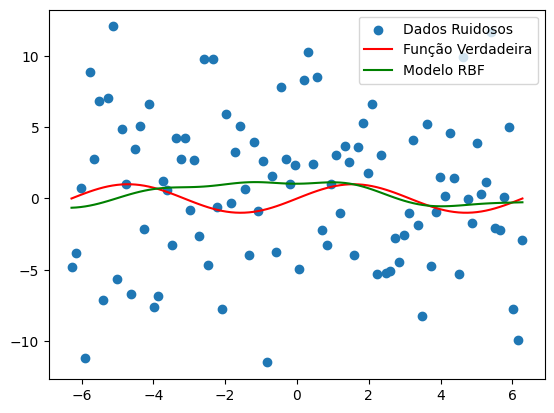

In [69]:
# Gera dados
x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
e = np.random.normal(0, 5, len(x))

y_verdadeiro = np.sin(x)
y_ruidoso = y_verdadeiro + e

# Cria e treina o modelo RBF
num_bases = 6
taxa_aprendizado = 0.001
num_epocas = 100

modelo_rbf = ModeloRBF(num_bases, taxa_aprendizado, num_epocas)
modelo_rbf.treinar(x, y_ruidoso)

# Faz previsões usando o modelo RBF treinado
y_rbf = modelo_rbf.prever(x)

# Visualiza os dados e o modelo RBF
plt.scatter(x, y_ruidoso, label='Dados Ruidosos')
plt.plot(x, y_verdadeiro, color='red', label='Função Verdadeira')
plt.plot(x, y_rbf, color='green', label='Modelo RBF')
plt.legend()
plt.show()


#### 2) Explore os códigos do modelo de regressão linear utilizados nos dados de diabetes do Sklearn.
##### a) Teste outros scores no modelo.
##### b) Teste outros parâmetros para a função SGDRegression.

In [2]:
from sklearn import datasets
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

class MySklearningModel:
    def __init__(self, model, df, independent_variable_list, dependent_variable, cross_validator=None):
        self.model = model
        self.cross_validator = cross_validator
        self.independent_variable_list = independent_variable_list
        self.dependent_variable = dependent_variable
        self.X = df[self.independent_variable_list].values
        self.y = np.squeeze(df[[self.dependent_variable]].values)

    def run_sklearn_regression(self, score_list):
        scalar = StandardScaler()
        pipeline = Pipeline([('transformer', scalar), ('estimator', self.model)])
        results = model_selection.cross_validate(pipeline, self.X, self.y, cv=self.cross_validator, scoring=score_list, return_train_score=True)
        
        for score in score_list:
            print(f'\n{score}:')
            print(f'Train - Mean: {np.mean(results["train_" + score])} Standard Error: {np.std(results["train_" + score])}')
            print(f'Test - Mean: {np.mean(results["test_" + score])} Standard Error: {np.std(results["test_" + score])}')

    def fit_sklearn_regression(self):
        self.model.fit(self.X, self.y)
        
    def get_parameters(self):
        print(f'\nIntercept: {self.model.intercept_}')
        print(f'Coefficients: {self.model.coef_}')

class SklearnDatasets:
    def __init__(self, loadFunction, targetName='Target'):
        self.loadFunction = loadFunction
        self.targetName = targetName
        
    def dataset_to_dataframe(self):
        data = self.loadFunction()
        self.featuresNames = list(data.feature_names)
        targetData = data.target
        featuresData = data.data
        self.df = pd.DataFrame(featuresData, columns=self.featuresNames)
        self.df[self.targetName] = targetData

# Load Data
california_house = SklearnDatasets(datasets.fetch_california_housing, 'HousePrice')
california_house.dataset_to_dataframe()
df = california_house.df
independent_variable_list = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
number_splits = 5
dependent_variable = 'HousePrice'
scores_list = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

print('SGD')
model = linear_model.SGDRegressor(penalty=None, tol=1e-8, max_iter=100000, learning_rate='constant', eta0=0.0000001)
cross_validator = model_selection.KFold(n_splits=number_splits, shuffle=True, random_state=0)
my_linear_model = MySklearningModel(model, df, independent_variable_list, dependent_variable, cross_validator)

my_linear_model.run_sklearn_regression(scores_list)
my_linear_model.fit_sklearn_regression()
# my_linear_model.get_parameters()


SGD

neg_mean_squared_error:
Train - Mean: -0.6124813919738553 Standard Error: 0.006061804384220803
Test - Mean: -0.6180214564117346 Standard Error: 0.024653384281377654

neg_mean_absolute_error:
Train - Mean: -0.5743769084837945 Standard Error: 0.0018244653583536054
Test - Mean: -0.5748838669241212 Standard Error: 0.004790140744765508

r2:
Train - Mean: 0.5400286682998382 Standard Error: 0.002987621150366132
Test - Mean: 0.5359439120911618 Standard Error: 0.012333873604561377


In [78]:
### Modelagem
# Ao experimentar com o SGDRegressor no seu código, existem vários fatores interessantes e importantes
# que você pode considerar ajustar para explorar os efeitos no desempenho do modelo. 
# Sempre podemos checar os parâmetros disponíveis de uma dada classe passando o mouse nela e analisando
# a documentação.
# Aqui estão alguns parâmetros-chave para se concentrar:

# 1. Função de Perda (loss):
#    A escolha da função de perda pode impactar significativamente o comportamento do modelo e sua
#    capacidade de lidar com valores discrepantes. Experimente diferentes funções de perda, como
#    'squared_error', 'huber', 'epsilon_insensitive' ou 'squared_epsilon_insensitive'.

# 2. Regularização (penalty, alpha, l1_ratio):
#    A regularização ajuda a prevenir o overfitting e melhora a generalização do seu modelo. Experimente
#    diferentes tipos de penalização ('l2', 'l1', 'elasticnet' ou None), ajuste a força da regularização
#    usando alpha e explore diferentes proporções de mistura usando l1_ratio se estiver usando penalização
#    'elasticnet'.

# 3. Taxa de Aprendizado (learning_rate, eta0, power_t):
#    A taxa de aprendizado determina o tamanho do passo em cada iteração do processo de otimização. Você
#    pode experimentar com diferentes escalas de taxa de aprendizado ('constant', 'optimal', 'invscaling',
#    'adaptive') e definir a taxa de aprendizado inicial eta0. O expoente power_t afeta a taxa de
#    diminuição da taxa de aprendizado na escala 'invscaling'.

# 4. Parada Antecipada (early_stopping, validation_fraction, n_iter_no_change):
#    Ativar a parada antecipada pode prevenir o overfitting ao interromper o processo de treinamento quando
#    o escore de validação não estiver mais melhorando. Ajuste validation_fraction para determinar a porção
#    dos dados de treinamento usada para validação e defina n_iter_no_change para especificar o número de
#    iterações sem melhoria necessárias para acionar a parada antecipada.

# 5. Número Máximo de Iterações (max_iter, tol):
#    O número de iterações afeta por quanto tempo o processo de treinamento continua. Você pode aumentar ou
#    diminuir max_iter para controlar o número de épocas. Defina tol para determinar o critério de parada
#    para a parada antecipada com base na perda ou no escore de validação.

# 6. Embaralhamento de Dados (shuffle):
#    Experimente se deve ou não embaralhar os dados de treinamento após cada época. O embaralhamento pode
#    ajudar a evitar que o modelo fique preso em mínimos locais.

### Cross validation
# Existem diversas opções de modelos de validação cruzada disponíveis no scikit-learn. 
# No exemplo, usamos 'KFold', e o código está implementado de forma a podermos modificar facilmente
# nosso modelo de validação cruzada. Caso não definirmos nenhum modelo específico como fazemos na linha
# "cross_validator = ...", o valor padrão para esse parâmetro na nossa classe é "None", o que significa
# que o modelo de validação cruzada padrão do scikit-learn será utilizado (usará 5 folds, você pode 
# checar isso e o valor padrão de outras variáveis verificando a documentação da classe).
# Podemos explorar algumas delas na documentação:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

### Scoring
# Também existem diversas opções de métricas de avaliação disponíveis no scikit-learn.
# No exemplo, usamos 'neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'.
# Podemos explorar algumas delas na documentação:
# https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

In [6]:
### Otimização de Hiperparâmetros

# E como eu vou saber quais parâmetros devo ajustar?

# O impacto desses parâmetros pode variar com base no seu conjunto de dados e problema. É uma boa prática 
# usar técnicas como busca em grade (GridSearchCV) ou busca aleatória (RandomSearchCV) para explorar uma ampla variedade de
# combinações de parâmetros e avaliar seu impacto no desempenho do modelo usando métodos adequados de validação.
# Essas opções de otimizadores de hiper-parâmetros estão disponíveis no scikit-learn:
# https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers

# Aqui, modificamos um pouco a nossa classe para podemos usar um otimizador de hiperparâmetros (GridSearchCV)
# Isso demorará bem mais pra rodar, já que vamos rodar o modelo várias vezes com diferentes parâmetros, e
# provavelmente a melhor forma de fazer isso é usando o Google Colab.
# O parâmetro 'verbose' do GridSearchCV nos avisa quantos fits vamos rodar no total no nosso problema.
# Além disso, como justamente estamos otimizando os hiperparâmetros com base em um score, não usamos uma
# lista de scores no cross_validate, mas sim um único score. No caso, usamos o neg_mean_squared_error.

# Você pode estar se perguntando como esse processo funciona e como a divisão entre treino e teste é feita.
# No processo de ajuste de hiperparâmetros usando o GridSearchCV, os dados são divididos em conjuntos de treinamento
# e teste dentro de cada dobra da validação cruzada por baixo do capô. Isso garante que os hiperparâmetros do modelo sejam otimizados
# com base no desempenho nos dados de treinamento, enquanto são validados nos dados de teste.
# Assim, estamos fazendo cross-validation e otimização de hiperparâmetros ao mesmo tempo.

# Aqui está como ocorre a divisão entre treinamento e teste durante a otimização de hiperparâmetros:

# 1. No processo do GridSearchCV, para cada combinação de hiperparâmetros definida em param_grid, os seguintes passos são executados:
#    - Os dados de treinamento são divididos em conjunto de treinamento e conjunto de validação (conjunto de teste para a otimização de hiperparâmetros)
#      com base no validador cruzado especificado (por exemplo, KFold).
#    - O modelo é treinado no conjunto de treinamento usando a combinação atual de hiperparâmetros.
#    - O desempenho do modelo é avaliado no conjunto de validação usando a métrica de pontuação especificada (por exemplo, neg_mean_squared_error).

# 2. Após avaliar todas as combinações de hiperparâmetros para todas as dobras, os hiperparâmetros que resultam no melhor
#    escore de validação são selecionados como "melhores parâmetros".

# 3. O modelo com os "melhores parâmetros" é então usado para avaliação adicional ou previsões.


from sklearn.model_selection import GridSearchCV

class MySklearningModel:
    def __init__(self, model, df, independent_variable_list, dependent_variable, cross_validator=None):
        self.model = model
        self.cross_validator = cross_validator
        self.independent_variable_list = independent_variable_list
        self.dependent_variable = dependent_variable
        self.X = df[self.independent_variable_list].values
        self.y = np.squeeze(df[[self.dependent_variable]].values)

    def hyperparameter_tuning(self, param_grid, score):
        scalar = StandardScaler()
        pipeline = Pipeline([('transformer', scalar), ('estimator', self.model)])
        grid_search = GridSearchCV(pipeline, param_grid, cv=self.cross_validator, scoring=score, refit=False, verbose=1)
        grid_search.fit(self.X, self.y)
        
        print(f'Best Parameters: {grid_search.best_params_}')
        print(f'Best {score}: {grid_search.best_score_}')

    def fit_sklearn_regression(self):
        self.model.fit(self.X, self.y)
        
    def get_parameters(self):
        print(f'\nIntercept: {self.model.intercept_}')
        print(f'Coefficients: {self.model.coef_}')


independent_variable_list = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
number_splits = 5
dependent_variable = 'HousePrice'

# Agora, precisamos de um grid de parâmetros da nossa escolha a serem testados pelo nosso otimizador
# Vamos testar valores diferentes para alpha, l1_ratio e learning_rate:

param_grid = {
    'estimator__alpha': list(np.logspace(-4, 2, 10)),
    'estimator__l1_ratio': [0.1, 0.25, 0.5, 0.75, 1],
}

print('SGD')
model = linear_model.SGDRegressor(penalty=None, tol=1e-8, max_iter=10000, learning_rate='constant', eta0=0.0000001)
cross_validator = model_selection.KFold(n_splits=number_splits, shuffle=True, random_state=0)
my_linear_model = MySklearningModel(model, df, independent_variable_list, dependent_variable, cross_validator)

# Otimização de hiperparâmetros com base no score neg_mean_squared_error:
my_linear_model.hyperparameter_tuning(param_grid, score='neg_mean_squared_error')


SGD
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/r2/Code/ml-comp-methods/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/r2/Code/ml-comp-methods/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/r2/Code/ml-comp-methods/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/r2/Code/ml-comp-methods/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter t